# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных:
[https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Общая информация

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


***
### Вывод

* Столбец `RowNumber` дублирует индекс таблицы, можно удалить.
* Столбец `CustomerId` — уникальный идентификатор клиента — не нужен для обучения модели.
* Столбец `Surname` — фамилия — не нужен для обучения модели.
* Столбец `Geography` — страна проживания — категориальный признак, который нужно преобразовать методом `one-hot-encoding`.
* Столбец `Gender` — пол — категориальный признак, который нужно преобразовать методом `one-hot-encoding`.
* Столбец `Tenure` — сколько лет человек является клиентом банка — есть пропуски (9.1%), надо заменить на среднее.
* Необходимо переименовать столбцы.<br><br>
***

## Подготовка данных

### Удаление столбцов

In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

### Замена категориальных признаков

In [6]:
data = pd.get_dummies(data, drop_first=True)

### Столбец `Tenure`

In [7]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mean()).astype(int)

### Замена названий столбцов 

In [8]:
data.columns = data.columns.str.lower()
columns = {
    'rownumber': 'row_number',
    'customerid': 'customer_id',
    'creditscore': 'credit_score',
    'numofproducts': 'num_of_products',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'estimatedsalary': 'estimated_salary',
}
data = data.rename(columns=columns)

* `credit_score` — кредитный рейтинг
* `geography` — страна проживания
* `gender` — пол
* `age` — возраст
* `tenure` — сколько лет человек является клиентом банка
* `balance` — баланс на счёте
* `num_of_products` — количество продуктов банка, используемых клиентом
* `has_cr_card` — наличие кредитной карты
* `is_active_member` — активность клиента
* `estimated_salary` — предполагаемая зарплата
* `exited` — целевой признак — факт ухода клиента

In [9]:
data.tail()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1
9999,792,28,4,130142.79,1,1,0,38190.78,0,0,0,0


***
### Вывод

* Лишние столбцы удалены.
* Категориальные признаки заменены методом `one-hot-encoding`.
* Заполнены пропуски в столбце `tenure`.
* Названия столбцов переименованы.
* Столбцы: `credit_score`, `age`, `tenure`, `balance`, `num_of_products`, `estimated_salary`;  
    содержат количественные признаки, необходимо масштабировать.
* Попарные зависимости (sns.pairplot) не показали каких-то чётких взаимосвязей.<br><br>
***

## Подготовка выборок

### Формирование выборок

In [10]:
features = data.drop(['exited'], axis=1)
target = data['exited']

In [11]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.50, random_state=12345
)

In [12]:
print('Разделение выборки в следующих пропорциях:')
print(f'{(len(features_train)/len(data)):.0%} — тренировочная;')
print(f'{(len(features_test)/len(data)):.0%} — тестовая;')
print(f'{(len(features_valid)/len(data)):.0%} — валидационная.')

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


### Масштабирование количественных признаков

In [13]:
pd.options.mode.chained_assignment = None

numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

pd.options.mode.chained_assignment = 'warn'

In [14]:
features_train.tail()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
4478,-1.073677,-0.752805,-0.338174,-1.233163,0.830152,0,1,-1.278361,0,0,1
4094,-1.447531,-0.942612,1.833088,-1.233163,0.830152,0,1,-1.281307,0,0,1
3492,0.027113,0.575842,-0.338174,-0.310229,-0.891560,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.338174,-1.233163,0.830152,0,1,-1.128539,0,0,0
4578,0.400966,-0.088482,-1.423805,-1.233163,0.830152,0,0,-0.949841,0,0,1


***
### Вывод

* Выборки сформированы.
* Количественные признаки отмасштабированы.<br><br>
***

## Исследование задачи

### Баланс целевого признака

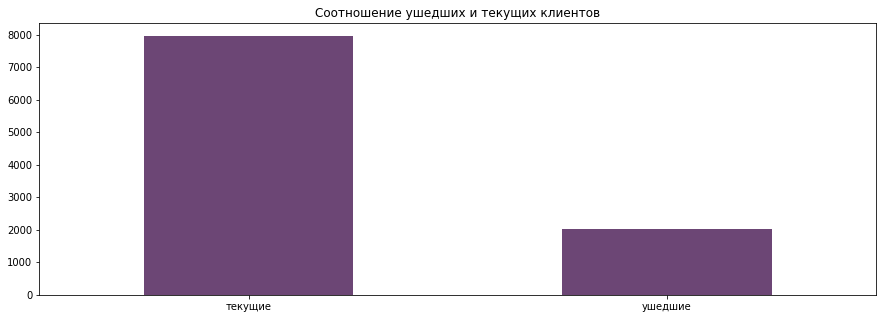

In [15]:
plot = data['exited'].value_counts().plot(
    kind='bar', figsize=(15, 5), title='Соотношение ушедших и текущих клиентов', rot=0, color='#6c4675'
)
plot.set_xticklabels( ('текущие', 'ушедшие') )
plt.show()

Баланса нет, соотношение 1 (текущие) : 4 (ушедшие).

### Исследование моделей

Метод для показа метрик

In [16]:
def show_metrics(model, features, target, model_name):
    predictions = model.predict(features)
    probabilities = model.predict_proba(features)[:, 1]
    metrics = {
        'F1-мера': [f'{f1_score(target, predictions):.0%}'],
        'Полнота (recall)': [f'{recall_score(target, predictions):.0%}'],
        'AUC-ROC метрика': [f'{roc_auc_score(target, probabilities):.0%}'],
        'Точность (precision)': [f'{precision_score(target, predictions):.0%}'],
        'Доля правильных ответов (accuracy)': [f'{accuracy_score(target, predictions):.0%}'],
    }
    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
    df_metrics = df_metrics.rename(columns={0: model_name})
    display(df_metrics)

#### Модель «Дерево решений» 

In [17]:
best_depth = 0
best_f1 = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 53.4% при глубине 6


##### Метрики

In [18]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345)
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,53%
Полнота (recall),41%
AUC-ROC метрика,84%
Точность (precision),76%
Доля правильных ответов (accuracy),85%


#### Модель «Случайный лес»

In [19]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(51, 52, 1):
    for depth in range(17, 18):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 56.0% при количестве «деревьев» 51 и при глубине 17


##### Метрики

In [20]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345)
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,56%
Полнота (recall),45%
AUC-ROC метрика,85%
Точность (precision),74%
Доля правильных ответов (accuracy),85%


 #### Модель «Логистическая регрессия»

In [21]:
model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,27%
Полнота (recall),18%
AUC-ROC метрика,74%
Точность (precision),52%
Доля правильных ответов (accuracy),79%


***
### Вывод

* Наиболее близкая метрика F1 у модели «Случайный лес».
* Тем не менее даже у этой модели метрика F1 — 56% — меньше необходимой (59%).<br><br>
***

## Борьба с дисбалансом

### Расчёт метрик с параметром балансировки «весов».

####  Модель «Дерево решений»

In [22]:
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 58.1% при глубине 5


##### Метрики

In [23]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,58%
Полнота (recall),66%
AUC-ROC метрика,84%
Точность (precision),52%
Доля правильных ответов (accuracy),80%


#### Модель «Случайный лес»

In [24]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(100, 102, 1):
    for depth in range(8, 9):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 62.3% при количестве «деревьев» 101 и при глубине 8


##### Метрики

In [25]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,62%
Полнота (recall),68%
AUC-ROC метрика,86%
Точность (precision),58%
Доля правильных ответов (accuracy),83%


#### Модель «Логистическая регрессия»

In [26]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,48%
Полнота (recall),65%
AUC-ROC метрика,74%
Точность (precision),38%
Доля правильных ответов (accuracy),70%


#### Промежуточный вывод

* Наиболее близкая метрика F1 всё ещё у модели «Случайный лес».</br>
* Метрика F1 — 62% — стала выше необходимой (59%).

### Балансировка методами upsampling и downsampling

Разбиение целевого признака на подклассы.

In [27]:
target_one = target[target == 1]
target_zero = target[target == 0]
features_one = features[target == 1]
features_zero = features[target == 0]
print(f'Количество target_one: {target_one.count():.0f}\nКоличество target_zero: {target_zero.count():.0f}')
print(f'Количество features_one: {features_one["age"].count():.0f}\nКоличество features_zero: {features_zero["age"].count():.0f}')

Количество target_one: 2037
Количество target_zero: 7963
Количество features_one: 2037
Количество features_zero: 7963


Наименьший класс — target_one / features_one — ушедшие.

#### Метод upsampling

In [28]:
repeat = 5
upsampling_features = pd.concat([features_zero] + [features_one]*repeat)
upsampling_target = pd.concat([target_zero] + [target_one]*repeat)
upsampling_features, upsampling_target = shuffle(upsampling_features, upsampling_target, random_state=12345)

##### Модель «Дерево решений»

In [29]:
best_depth = 0
best_f1 = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(upsampling_features, upsampling_target)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 39.2% при глубине 4


###### Метрики

In [30]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(upsampling_features, upsampling_target)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,39%
Полнота (recall),45%
AUC-ROC метрика,62%
Точность (precision),35%
Доля правильных ответов (accuracy),71%


##### Модель «Случайный лес»

In [31]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(1, 11, 1):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(upsampling_features, upsampling_target)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 39.2% при количестве «деревьев» 1 и при глубине 2


###### Метрики

In [32]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(upsampling_features, upsampling_target)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,39%
Полнота (recall),45%
AUC-ROC метрика,62%
Точность (precision),35%
Доля правильных ответов (accuracy),71%


##### Модель «Логистическая регрессия»

In [33]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(upsampling_features, upsampling_target)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,48%
Полнота (recall),57%
AUC-ROC метрика,72%
Точность (precision),41%
Доля правильных ответов (accuracy),73%


#### Метод downsampling

In [34]:
fraction = 0.25
downsampling_features = pd.concat([features_zero.sample(frac=fraction, random_state=12345)] + [features_one])
downsampling_target = pd.concat([target_zero.sample(frac=fraction, random_state=12345)] + [target_one])
downsampling_features, downsampling_target = shuffle(downsampling_features, downsampling_target, random_state=12345)

##### Модель «Дерево решений»

In [35]:
best_depth = 0
best_f1 = 0
for depth in range(1, 5):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(downsampling_features, downsampling_target)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print(f'Наилучшая метрика F1: {best_f1:.1%} при глубине {best_depth}')

Наилучшая метрика F1: 39.2% при глубине 4


###### Метрики

In [36]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(downsampling_features, downsampling_target)
show_metrics(model, features_valid, target_valid, 'Дерево решений')

,Дерево решений
F1-мера,39%
Полнота (recall),45%
AUC-ROC метрика,62%
Точность (precision),35%
Доля правильных ответов (accuracy),71%


##### Модель «Случайный лес»

In [37]:
best_depth = 0
best_est = 0
best_f1 = 0
for est in range(35, 40, 1):
    for depth in range(6, 7):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(downsampling_features, downsampling_target)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
print(f'Наилучшая метрика F1: {best_f1:.1%} при количестве «деревьев» {best_est} и при глубине {best_depth}')

Наилучшая метрика F1: 41.4% при количестве «деревьев» 37 и при глубине 6


###### Метрики

In [38]:
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(downsampling_features, downsampling_target)
show_metrics(model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,41%
Полнота (recall),58%
AUC-ROC метрика,65%
Точность (precision),32%
Доля правильных ответов (accuracy),65%


##### Модель «Логистическая регрессия»

In [39]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(downsampling_features, downsampling_target)
show_metrics(model, features_valid, target_valid, 'Логистическая регрессия')

,Логистическая регрессия
F1-мера,48%
Полнота (recall),56%
AUC-ROC метрика,72%
Точность (precision),42%
Доля правильных ответов (accuracy),74%


#### Промежуточный вывод

* Балансировка методами upsampling и downsampling не даёт улучшение F1-метрики.
* Наилучшая метрика F1 у «Логистической регрессии» — 48% — меньше необходимой (59%).

***
### Вывод

* Балансировка методами upsampling и downsampling не даёт улучшение F1-метрики.
* Наиболее близкая метрика F1 у модели «Случайный лес» при балансировке «весов» — 62% — выше необходимой (59%).<br><br>
***

## Тестирование модели

### Формирование финальной модели

Финальная модель — «Случайный лес».  
Которая показала наилучшую метрику F1:  
62.3% при количестве «деревьев» 101 и при глубине 8 с учётом балансировки.  

In [40]:
final_model = RandomForestClassifier(n_estimators=101, max_depth=8, random_state=12345, class_weight='balanced')
final_model.fit(features_train, target_train)
show_metrics(final_model, features_valid, target_valid, 'Случайный лес')

,Случайный лес
F1-мера,62%
Полнота (recall),68%
AUC-ROC метрика,86%
Точность (precision),58%
Доля правильных ответов (accuracy),83%


#### Сравнение финальной модели с константной

In [41]:
target_constraint = pd.Series([0]*len(target_valid))
final_predictions = final_model.predict(features_valid)
final_probabilities = final_model.predict_proba(features_valid)[:, 1]
print(f'Точность константной модели: {accuracy_score(target_valid, target_constraint):.0%}')
print(f'Точность финальной модели: {accuracy_score(target_valid, final_predictions):.0%}')
print(f'AUC-ROC метрика константной модели: {roc_auc_score(target_valid, target_constraint):.0%}')
print(f'AUC-ROC метрика финальной модели: {roc_auc_score(target_valid, final_probabilities):.0%}')

Точность константной модели: 79%
Точность финальной модели: 83%
AUC-ROC метрика константной модели: 50%
AUC-ROC метрика финальной модели: 86%


#### Промежуточный вывод

* Точность финальной модели выше константной, можно считать финальную модель «рабочей».

### Тестирование финальной модели

In [42]:
show_metrics(final_model, features_test, target_test, 'Финальная модель')

,Финальная модель
F1-мера,63%
Полнота (recall),68%
AUC-ROC метрика,86%
Точность (precision),58%
Доля правильных ответов (accuracy),83%


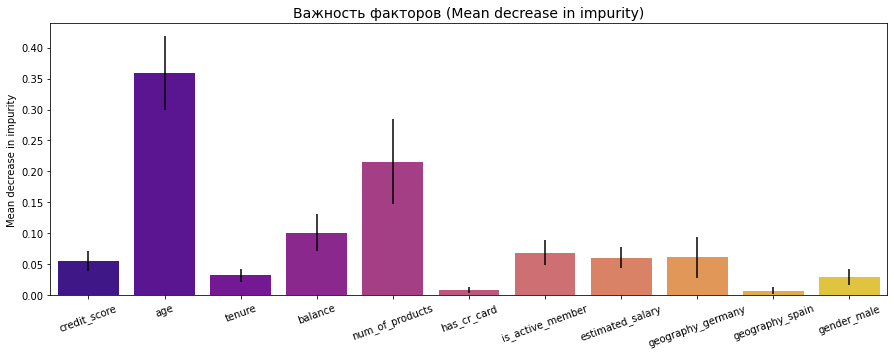

In [43]:
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
importances = final_model.feature_importances_
forest_importances = pd.Series(importances, index=features.columns)

plt.figure(figsize=(15, 5))
fig = sns.barplot(x=forest_importances.index, y=forest_importances, palette='plasma', yerr=std)
fig.set_title('Важность факторов (Mean decrease in impurity)', fontsize=14)
fig.set_ylabel('Mean decrease in impurity')
plt.setp(fig.get_xticklabels(),rotation=20)
plt.show()

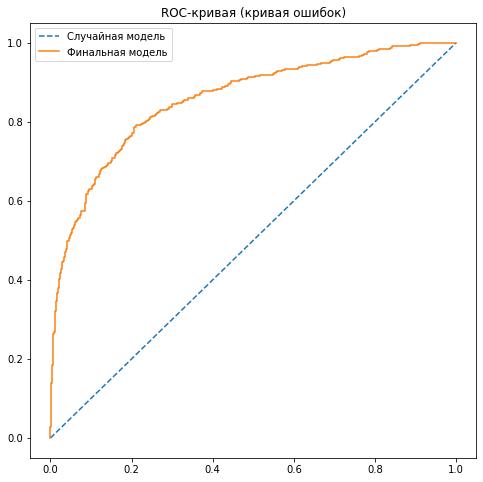

In [44]:
test_probabilities = final_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, test_probabilities)
plt.figure(figsize=(8, 8))
plt.title('ROC-кривая (кривая ошибок)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.legend(('Случайная модель', 'Финальная модель'))
plt.show()

## Общий вывод
* Лучше всего отработали модели при сбалансированных «весах».
* Финальная модель прошла проверку на адекватность и достигла поставленной задачи по метрике F1-score: 63% > 59%.
* AUC-ROC метрика финальной модели — 86% — сильно выше показателя случайной модели.  
    Модель с точностью в 58% предскажет уход клиента из банка.  
    При этом верно определяет массив ушедших клиентов — 68%.  